# Testing Debye formulations and implementations

Using the AgPtPOP xyz to generate RDFs from, for a more exhaustive test of the various discrete- and density-based Debye formulations. 


In [170]:
%reset -f
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sys, glob
sys.path.append('../')

import matplotlib, glob, os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 16})

import MDAnalysis as mda 
from MDAnalysis.analysis.rdf import InterRDF

from cmm.xray.sgr import SGr, Damping
from cmm.xray.sgr2 import RDF, SGr as SGr2

from cmm.xray.debye import Debye

from ase.io import read

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
mda.__version__

'2.0.0'

Read in XYZ and make RDFs from it, calculate S(Q) from g(r) with the two current codes:

In [171]:
u = mda.Universe('../data/md/agptpop/agptpop_gs_constrained_almost_opt_resequenced.xyz')
u.trajectory[0].dimensions = [25, 25, 25, 90, 90, 90]

types = np.unique(u.atoms.elements)
selections = [u.select_atoms(f'element {t}') for t in types]

V = (25)**3 
sgr = SGr(V)
sgr.rdfs = []
stoich = {}

sgr2 = SGr2(V)
s_g2 = np.zeros(len(sgr2.qvec))

for s1 in selections:
    el1 = s1.atoms.elements[0]
    stoich[el1 + '_u'] = len(s1.atoms)
    for s2 in selections:
        if (s1 == s2) and len(s1.atoms) == 1: 
            continue  # only 1 of this type of atoms.
        rdf = InterRDF(s1, s2, nbins=10000, range=(0.0000, 12.5))
        rdf.run()
        r = rdf.results.bins
        g = rdf.results.rdf
        g[r < r[1]] = 0  # remove self-delta peak that should not be there
        
        el2 = s2.atoms.elements[0]
        
        # SGr1
        this_rdf = {'name':'g' + el1 + '_u-' + el2 + '_u',
                    'type1':el1, 'part1':'u',
                    'type2':el2, 'part2':'u',
                    'r':r,
                    'gr':g}
        sgr.rdfs.append(this_rdf)
        
        # SGr2
        rdf_obj = RDF(r, g, el1, el2, 'solute', 'solute')
        rdf_obj.n1 = len(s1.atoms)
        rdf_obj.n2 = len(s2.atoms)
        
        s_g2 += sgr2.scoh(rdf_obj)
        

        
        
sgr.set_stoichometry(stoich)
s_gr = sgr.calculate(sgr.rdfs, stoich)

/opt/tljh/user/envs/py38/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


Bookkeeping messages:
---------------------
---------------------

SAXSy Solvent Displaced Volume FF:
----------------------------------
----------------------------------

Second term:
------------
SOLUTE  : Ag_u:      1 - H_u :      8, KD:0.0, DV: Ag-H 
SOLUTE  : Ag_u:      1 - O_u :     20, KD:0.0, DV: Ag-O 
SOLUTE  : Ag_u:      1 - P_u :      8, KD:0.0, DV: Ag-P 
SOLUTE  : Ag_u:      1 - Pt_u:      2, KD:0.0, DV: Ag-Pt 
SOLUTE  : H_u :      8 - Ag_u:      1, KD:0.0, DV: H-Ag 
SOLUTE  : H_u :      8 - H_u :      8, KD:1.0, DV: H-H 
SOLUTE  : H_u :      8 - O_u :     20, KD:0.0, DV: H-O 
SOLUTE  : H_u :      8 - P_u :      8, KD:0.0, DV: H-P 
SOLUTE  : H_u :      8 - Pt_u:      2, KD:0.0, DV: H-Pt 
SOLUTE  : O_u :     20 - Ag_u:      1, KD:0.0, DV: O-Ag 
SOLUTE  : O_u :     20 - H_u :      8, KD:0.0, DV: O-H 
SOLUTE  : O_u :     20 - O_u :     20, KD:1.0, DV: O-O 
SOLUTE  : O_u :     20 - P_u :      8, KD:0.0, DV: O-P 
SOLUTE  : O_u :     20 - Pt_u:      2, KD:0.0, DV: O-Pt 
SOLUTE  

<IPython.core.display.Javascript object>


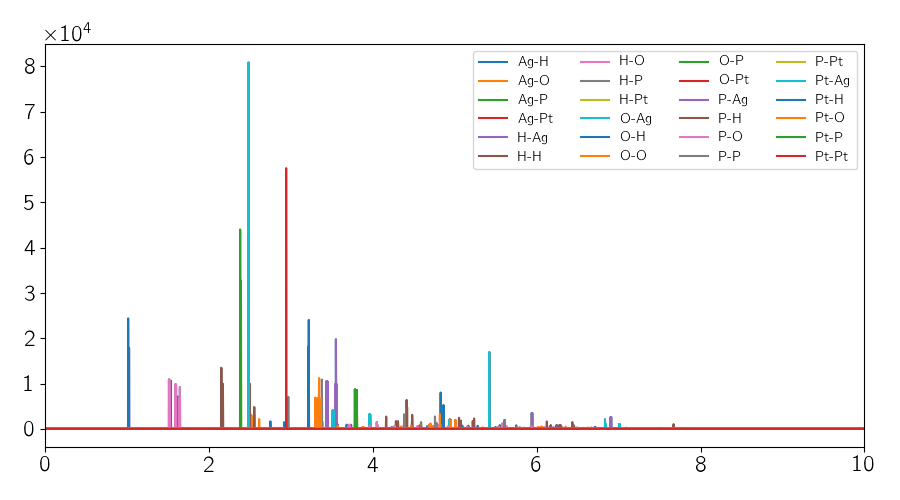

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
for rdf in sgr.rdfs:
    ax.plot(r, rdf['gr'], label=rdf['name'][1:].replace('_u', ''))
ax.legend(loc='best', fontsize=10, ncol=4)
ax.set_xlim([0, 10])
fig.tight_layout()

Test the SGR2 code as well

Also calculate S(Q) via the various Debye implementations for discrete distances:

<IPython.core.display.Javascript object>


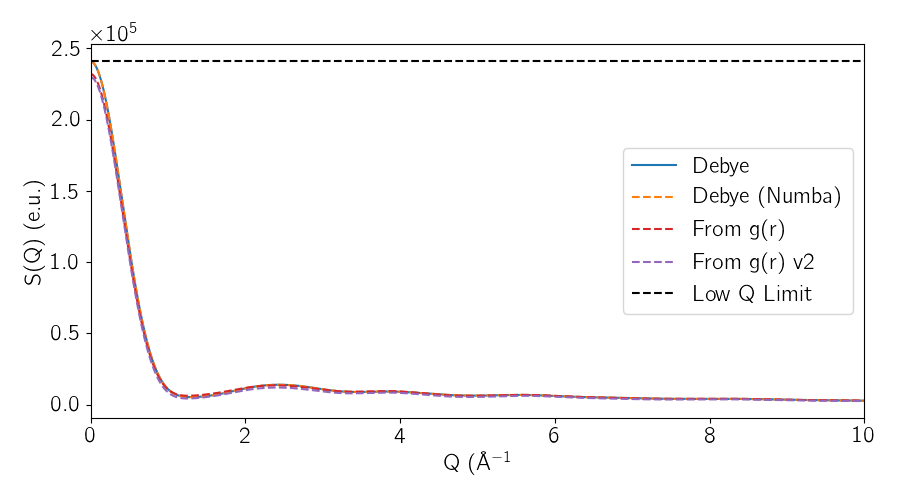

In [174]:
atoms = read('../data/md/agptpop/agptpop_gs_constrained_almost_opt_resequenced.xyz')
deb = Debye()
s_deb = deb.debye(atoms)
s_num = deb.debye_numba(atoms)

num_electrons_squared = sum(atoms.get_atomic_numbers())**2


fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, s_deb, 'C0', label='Debye')
ax.plot(deb.qvec, s_num, 'C1--', label='Debye (Numba)')
ax.plot(s_gr['q'], s_gr['s_u'], 'C3--', label='From g(r)')
ax.plot(sgr2.qvec, s_g2, 'C4--', label='From g(r) v2')
ax.plot(deb.qvec, np.ones_like(deb.qvec) * num_electrons_squared, 'k--', label='Low Q Limit')


ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');


The last remaining differences most likely arises from the numeric representation of the delta-distributions in r. 